\title{Use of *yt* in visualizing 3d outputs of Simpetus' MEEP Finite Difference Time Domain electromagnetic Field Solver}
\author{Steven K Armour}
\maketitle

# Introduction and Goal
[MEEP](https://meep.readthedocs.io/en/latest/) is an electromagnetic finite difference time domain solver created at MIT that is open source and maintained by [Simpetus](http://www.simpetus.com/). Where the name **MEEP** stands for *MIT Electromagnetic Equation Propagation*

The purpose  of this notebook is not to show how to utilize MEEP in python via it's official python environment(for that see the [read the docs](https://meep.readthedocs.io/en/latest/)) but instead show how to utilize it along with the python yt library as a result viewing tool as an alternative to VTK that meep and many other libraries that generate "volumetric" or high-density data have relied on till now 

If  one is interested in learning more about the use of the FDTD in solving electromagnetic problems I would recommend the (free) book by John Schneider *[Understanding the Finite-Difference Time-Domain
Method](https://www.eecs.wsu.edu/~schneidj/ufdtd/)*


Also, note that I have just started to explore the meep library and therefore I don't know as much about it as I would like to at the time of writing this guide in visualizing the output fields from a meep simulation in yt

# Installation 
see https://meep.readthedocs.io/en/latest/Installation/#conda-packages for install in meep. After that activate the meep virtual environment and install `jupyter` and `yt`

# libraries and additional functions

In [1]:
import meep as mp
import numpy as np
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr
import yt
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
from yt.visualization.volume_rendering.render_source import VolumeSource

from sympy import *
init_printing(use_latex='png')

%load_ext version_information
%version_information meep, yt, numpy, matplotlib, xarray, sympy

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Software versions
Python 3.6.5 64bit [GCC 7.2.0]
IPython 6.3.1
OS Linux 4.13.0 41 generic x86_64 with debian stretch sid
meep The 'meep' distribution was not found and is required by the application
yt 3.4.1
numpy 1.14.2
matplotlib 2.2.2
xarray 0.10.3
sympy 1.1.1
Mon May 21 11:30:49 2018 MDT

## function to calculate the Poynting (power) vector

In [2]:
x,y,z,f1,f2,f3 = symbols('x,y,z,f1,f2,f3', real=True)
Cartision = [x,y,z]

In [3]:
def Cross(X, Y, Coord=Cartision):
    return Matrix([X[1]*Y[2]-X[2]*Y[1], 
                   -(X[0]*Y[2]-X[2]*Y[0]), 
                   X[0]*Y[1]-X[1]*Y[0]])

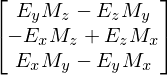

In [4]:
Ex, Ey, Ez, Mx, My, Mz, S=symbols('E_x, E_y, E_z, M_x, M_y, M_z, S')
PythongTMEq=Cross(Matrix([Ex, Ey, Ez]), Matrix([Mx, My, Mz]))
PythongTMEq

In [5]:
PythongTMXEqN=lambdify((Ey, Ez, My, Mz), PythongTMEq[0], dummify=False)
PythongTMYEqN=lambdify((Ex, Ez, Mx, Mz), PythongTMEq[1], dummify=False)
PythongTMZEqN=lambdify((Ex, Ey, My, Mx), PythongTMEq[2], dummify=False)

# Ex1
The first example is a 3D variation of the 2D strait waveguide variation  from example one of tutorial one from the meep read the docs (https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/)

## Setup  and meep Sim

Yee cell super size of size $16\mu m$ $8\mu m$ $8\mu m$

In [6]:
cell = mp.Vector3(16, 8, 8)

with the waveguide, its self-being infinite in size is (therefore ) not constrained propagation in a material with a dielectric strength of $\epsilon=12$

In [7]:
geometry = [mp.Block(mp.Vector3(1e20, 1e20, 1e20),
                     center=mp.Vector3(0, 0, 0),
                     material=mp.Medium(epsilon=12))]

The continuous radiative source is created at one end of the waveguide  slightly off center and has a vacuum wavelength of $\dfrac{\epsilon_0=1}{0.15\text{Hz} }=6.67\mu m$

In [8]:
sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     component=mp.Ez,
                     center=mp.Vector3(-7,0))]

utilize perfectly matched boundary layers

In [9]:
pml_layers = [mp.PML(1.0)]

pass the simulation to the meep *C++* internals

In [10]:
resolution = 10

In [11]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

run the simulation for 200-time steps before retrieving result (note that FDTD simulations are notoriously slow and this is not a python or computer issue it's just slow)

In [12]:
sim.run(until=200)

-----------
Initializing structure...
Meep progress: 0.05/200.0 = 0.0% done in 14.2s, 56811.8s to go
Meep progress: 1.85/200.0 = 0.9% done in 18.3s, 1957.9s to go
Meep progress: 3.6500000000000004/200.0 = 1.8% done in 22.4s, 1204.1s to go
Meep progress: 5.45/200.0 = 2.7% done in 26.5s, 945.4s to go
Meep progress: 7.25/200.0 = 3.6% done in 30.6s, 813.1s to go
Meep progress: 9.05/200.0 = 4.5% done in 34.7s, 732.0s to go
Meep progress: 10.850000000000001/200.0 = 5.4% done in 38.8s, 676.0s to go
Meep progress: 12.65/200.0 = 6.3% done in 42.8s, 634.5s to go
Meep progress: 14.450000000000001/200.0 = 7.2% done in 46.9s, 602.2s to go
Meep progress: 16.25/200.0 = 8.1% done in 51.0s, 576.8s to go
Meep progress: 18.05/200.0 = 9.0% done in 55.1s, 555.2s to go
Meep progress: 19.85/200.0 = 9.9% done in 59.1s, 536.7s to go
Meep progress: 21.650000000000002/200.0 = 10.8% done in 63.2s, 520.6s to go
Meep progress: 23.450000000000003/200.0 = 11.7% done in 67.3s, 506.4s to go
Meep progress: 25.25/200.0 =

## Capture the sim data in python numpy arrays
The transpose is because of the coordinate system the is inherently used in meep is $x$ vertical with respect to yt

In [13]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric).T


In [14]:
eps_data.shape

In [15]:
ExData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ex).T
EyData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ey).T
EzData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez).T

EMagData=np.sqrt(ExData**2+ EyData**2+EzData**2)

#ignore the units, its still something I need to sort out in yt
#bind the arrays into dictianrys to pass to yt
EFields={'Ex':(ExData, 'g/m**3'), 'Ey':(EyData, 'g/m**3'), 'Ez':(EzData,'g/m**3'),
        'EMag':(EMagData,'g/m**3')}

In [16]:
BxData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Bx).T
ByData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.By).T
BzData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Bz).T

BMagData=np.sqrt(BxData**2+ ByData**2+BzData**2)


#ignore the units, its still something I need to sort out in yt
#bind the arrays into dictianrys to pass to yt
BFields={'Bx':(BxData, 'g/m**3'), 'By':(ByData, 'g/m**3'), 'Bz':(BzData,'g/m**3'),
        'BMag':(BMagData,'g/m**3')}

In [17]:
SxData=PythongTMXEqN(EyData, EzData, ByData, BzData)
SyData=PythongTMYEqN(ExData, EzData, BxData, BzData)
SzData=PythongTMZEqN(ExData, EyData, ByData, BxData)

SMagData=np.sqrt(SxData**2+ SyData**2+SzData**2)

#ignore the units, its still something I need to sort out in yt
#bind the arrays into dictianrys to pass to yt
SFields={'Sx':(SxData, 'g/m**3'), 'Sy':(SyData, 'g/m**3'), 'Sz':(SzData,'g/m**3'),
        'SMag':(SMagData,'g/m**3')}


collect all the dictionaries into a single dictionary

In [18]:
Fields={**EFields, **BFields, **SFields}; 

## yt vis

### setup
since the data returned from meep is Generic Array Data the yt `load_uniform_grid` method can be used to load the data into yt
(see: http://yt-project.org/doc/examining/loading_data.html#generic-array-data)

In [20]:
#for the moment use the yt exsample boundary box till I fiure out 
#all the units used in meep
bbox = np.array([[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5]])
YTDataObj = yt.load_uniform_grid(Fields, eps_data.shape, length_unit="m", bbox=bbox, nprocs=64)

yt : [INFO     ] 2018-05-21 11:40:09,235 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-21 11:40:09,236 Parameters: domain_dimensions         = [ 80  80 160]
yt : [INFO     ] 2018-05-21 11:40:09,237 Parameters: domain_left_edge          = [-1.5 -1.5 -1.5]
yt : [INFO     ] 2018-05-21 11:40:09,238 Parameters: domain_right_edge         = [1.5 1.5 1.5]
yt : [INFO     ] 2018-05-21 11:40:09,239 Parameters: cosmological_simulation   = 0.0


In [21]:
YTDataObj.field_list

[('stream', 'BMag'),
 ('stream', 'Bx'),
 ('stream', 'By'),
 ('stream', 'Bz'),
 ('stream', 'EMag'),
 ('stream', 'Ex'),
 ('stream', 'Ey'),
 ('stream', 'Ez'),
 ('stream', 'SMag'),
 ('stream', 'Sx'),
 ('stream', 'Sy'),
 ('stream', 'Sz')]

### E fields

yt : [INFO     ] 2018-05-21 11:40:12,807 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:12,814 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:13,053 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:13,053 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


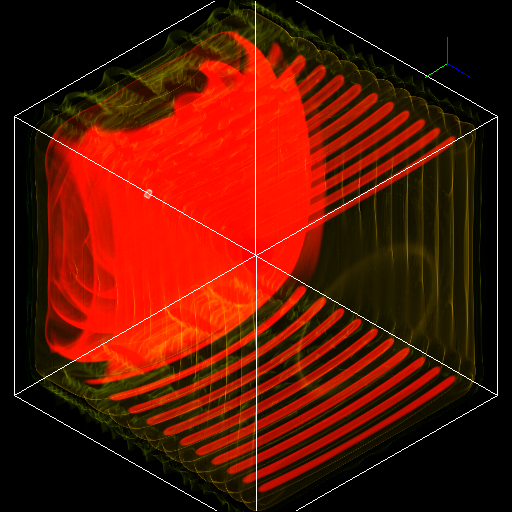

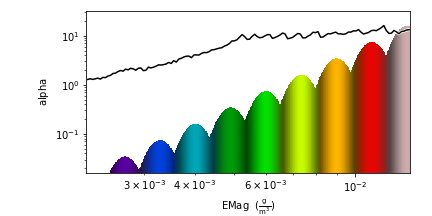

In [22]:
sc = yt.create_scene(YTDataObj, 'EMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('EMag')
scTF.set_bounds((abs(Fields['EMag'][0].mean()-Fields['EMag'][0].std()), Fields['EMag'][0].mean()+Fields['EMag'][0].std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='EMag')

yt : [INFO     ] 2018-05-21 11:40:19,805 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:19,812 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:19,991 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:19,991 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


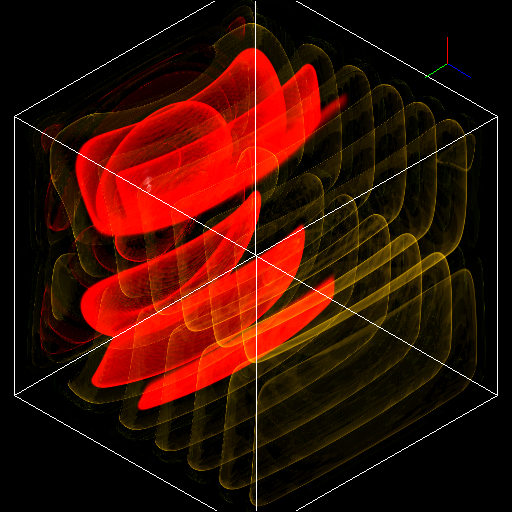

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/visualization/volume_rendering/transfer_functions.py:674: RuntimeWarning: invalid value encountered in double_scalars
  rel = (v - self.x_bounds[0])/(self.x_bounds[1] - self.x_bounds[0])
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.004521985020554287, right=0.004521985020554287
  'left=%s, right=%s') % (left, right))


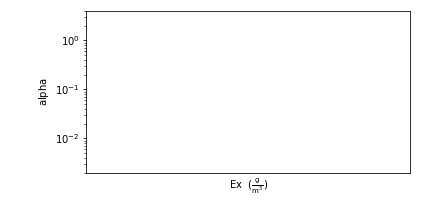

In [23]:
sc = yt.create_scene(YTDataObj, 'Ex')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ex')
scTF.set_bounds((abs(Fields['Ex'][0].mean()-Fields['Ex'][0].std()), Fields['Ex'][0].mean()+Fields['Ex'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ex')

yt : [INFO     ] 2018-05-21 11:40:25,903 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:25,908 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:26,079 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:26,079 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


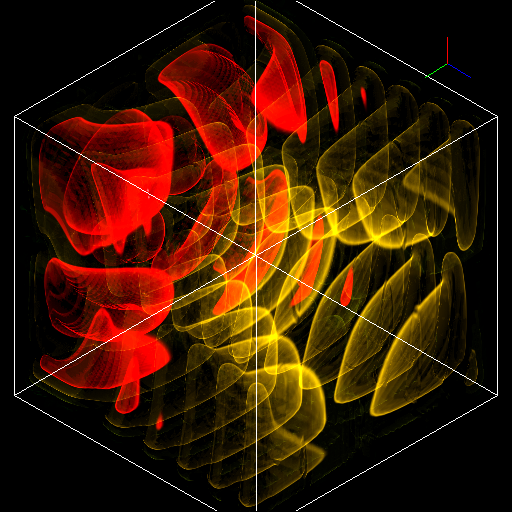

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/visualization/volume_rendering/transfer_functions.py:674: RuntimeWarning: invalid value encountered in double_scalars
  rel = (v - self.x_bounds[0])/(self.x_bounds[1] - self.x_bounds[0])
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0027115763024295365, right=0.0027115763024295365
  'left=%s, right=%s') % (left, right))


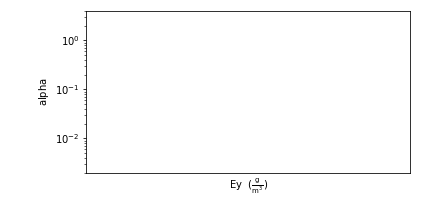

In [24]:
sc = yt.create_scene(YTDataObj, 'Ey')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ey')
scTF.set_bounds((abs(Fields['Ey'][0].mean()-Fields['Ey'][0].std()), Fields['Ey'][0].mean()+Fields['Ey'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ey')

yt : [INFO     ] 2018-05-21 11:40:31,418 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:31,424 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:31,584 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:31,584 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


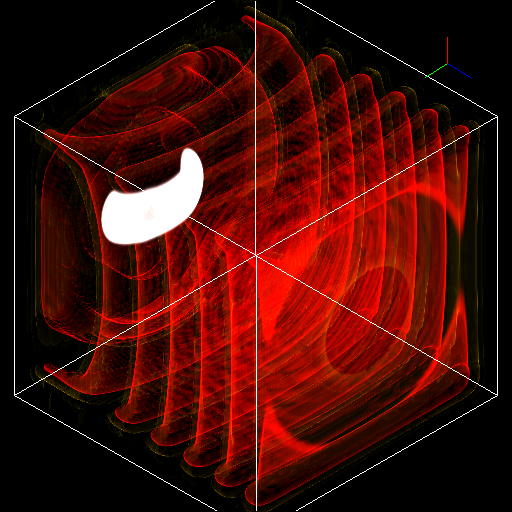

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


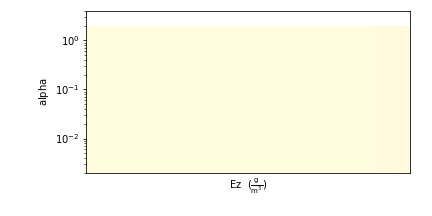

In [25]:
sc = yt.create_scene(YTDataObj, 'Ez')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ez')
scTF.set_bounds((abs(Fields['Ez'][0].mean()-Fields['Ez'][0].std()), Fields['Ez'][0].mean()+Fields['Ez'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ez')

###  B fields

yt : [INFO     ] 2018-05-21 11:40:38,087 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:38,093 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:38,235 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:38,236 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


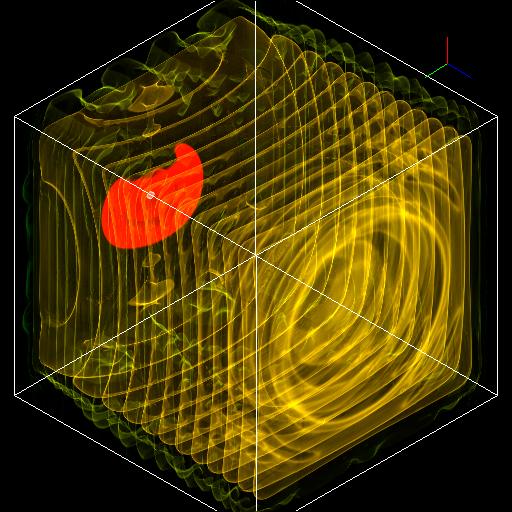

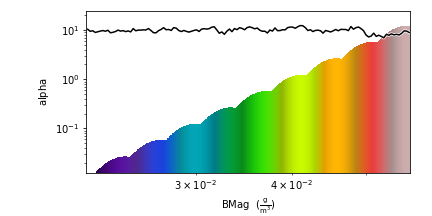

In [26]:
sc = yt.create_scene(YTDataObj, 'BMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('BMag')
scTF.set_bounds((abs(Fields['BMag'][0].mean()-Fields['BMag'][0].std()), Fields['BMag'][0].mean()+Fields['BMag'][0].std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='BMag')

yt : [INFO     ] 2018-05-21 11:40:45,790 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:45,796 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:45,979 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:45,980 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


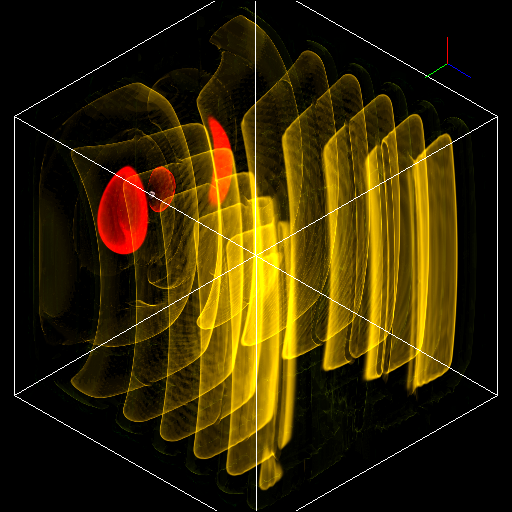

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/visualization/volume_rendering/transfer_functions.py:674: RuntimeWarning: invalid value encountered in double_scalars
  rel = (v - self.x_bounds[0])/(self.x_bounds[1] - self.x_bounds[0])
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.029465234502209007, right=0.029465234502209007
  'left=%s, right=%s') % (left, right))


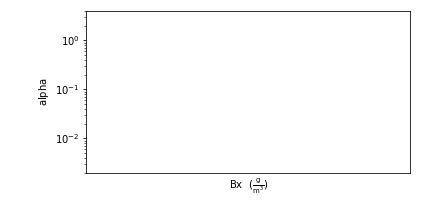

In [27]:
sc = yt.create_scene(YTDataObj, 'Bx')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Bx')
scTF.set_bounds((abs(Fields['Bx'][0].mean()-Fields['Bx'][0].std()), Fields['Bx'][0].mean()+Fields['Bx'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Bx')

yt : [INFO     ] 2018-05-21 11:40:51,125 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:51,130 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:51,304 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:51,305 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


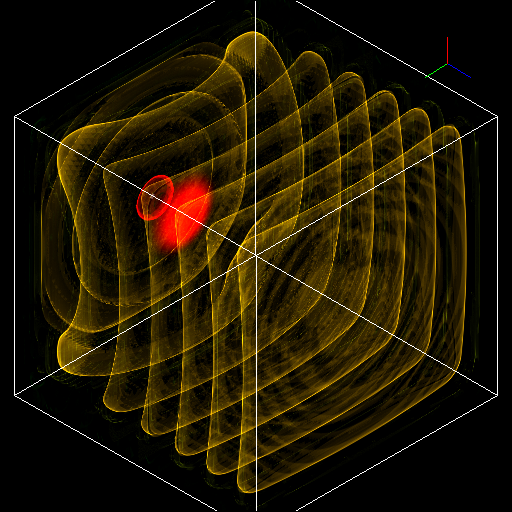

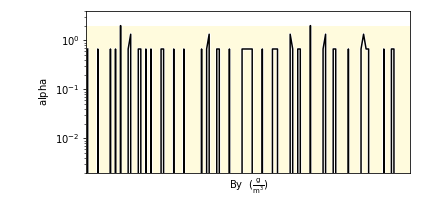

In [28]:
sc = yt.create_scene(YTDataObj, 'By')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('By')
scTF.set_bounds((abs(Fields['By'][0].mean()-Fields['By'][0].std()), Fields['By'][0].mean()+Fields['By'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='By')

yt : [INFO     ] 2018-05-21 11:40:57,001 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:40:57,006 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:40:57,188 Creating transfer function
yt : [INFO     ] 2018-05-21 11:40:57,189 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


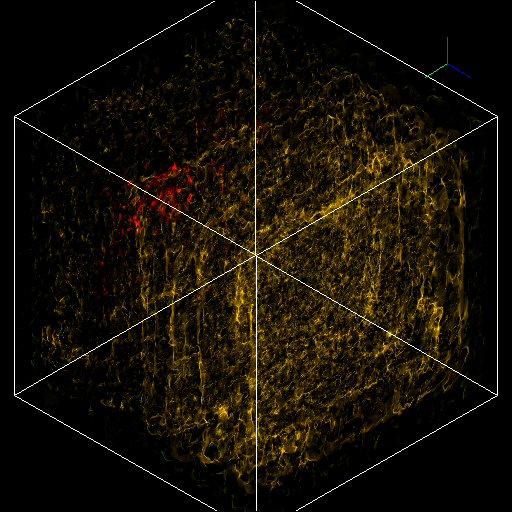

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


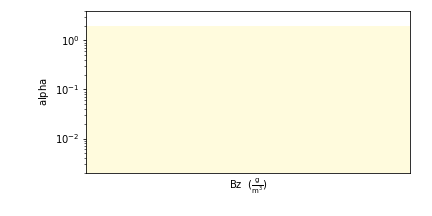

In [29]:
sc = yt.create_scene(YTDataObj, 'Bz')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Bz')
scTF.set_bounds((abs(Fields['Bz'][0].mean()-Fields['Bz'][0].std()), Fields['Bz'][0].mean()+Fields['Bz'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Bz')

### Power fields

yt : [INFO     ] 2018-05-21 11:41:02,761 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:41:02,767 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:41:02,882 Creating transfer function
yt : [INFO     ] 2018-05-21 11:41:02,882 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


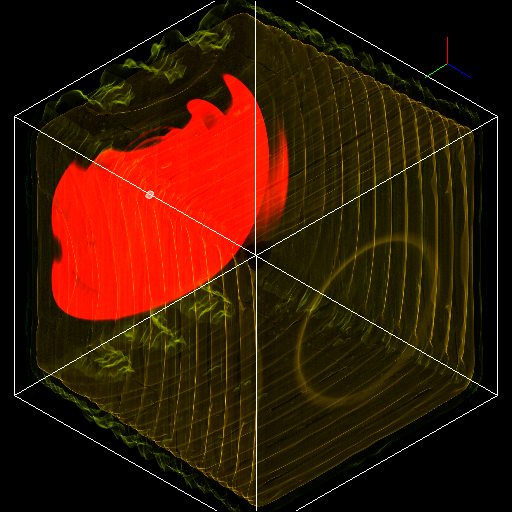

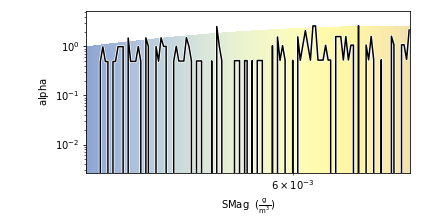

In [30]:
sc = yt.create_scene(YTDataObj, 'SMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('SMag')
scTF.set_bounds((abs(Fields['SMag'][0].mean()-Fields['SMag'][0].std()), Fields['SMag'][0].mean()+Fields['SMag'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='SMag')

yt : [INFO     ] 2018-05-21 11:41:10,651 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:41:10,656 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:41:10,800 Creating transfer function
yt : [INFO     ] 2018-05-21 11:41:10,801 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


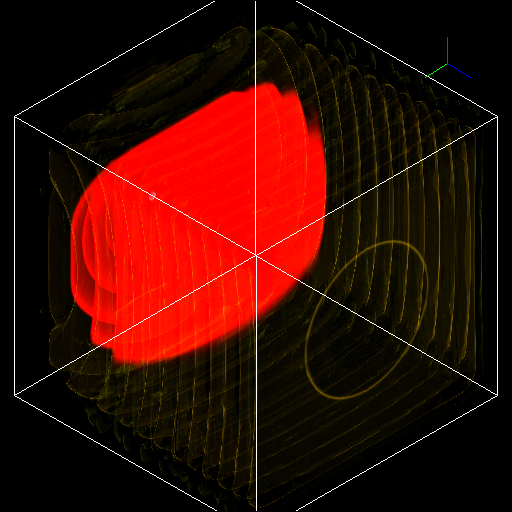

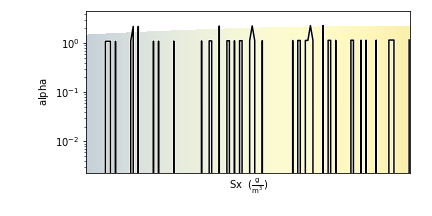

In [31]:
sc = yt.create_scene(YTDataObj, 'Sx')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Sx')
scTF.set_bounds((abs(Fields['Sx'][0].mean()-Fields['Sx'][0].std()), Fields['Sx'][0].mean()+Fields['Sx'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Sx')

yt : [INFO     ] 2018-05-21 11:41:17,114 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:41:17,120 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:41:17,281 Creating transfer function
yt : [INFO     ] 2018-05-21 11:41:17,282 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


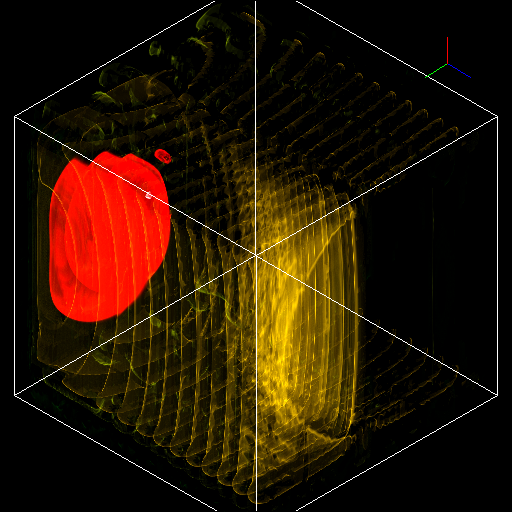

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/visualization/volume_rendering/transfer_functions.py:674: RuntimeWarning: invalid value encountered in double_scalars
  rel = (v - self.x_bounds[0])/(self.x_bounds[1] - self.x_bounds[0])
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.003914342215362542, right=0.003914342215362542
  'left=%s, right=%s') % (left, right))


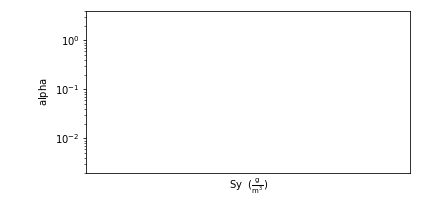

In [32]:
sc = yt.create_scene(YTDataObj, 'Sy')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Sy')
scTF.set_bounds((abs(Fields['Sy'][0].mean()-Fields['Sy'][0].std()), Fields['Sy'][0].mean()+Fields['Sy'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Sy')

yt : [INFO     ] 2018-05-21 11:41:22,801 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:41:22,806 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:41:22,986 Creating transfer function
yt : [INFO     ] 2018-05-21 11:41:22,986 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


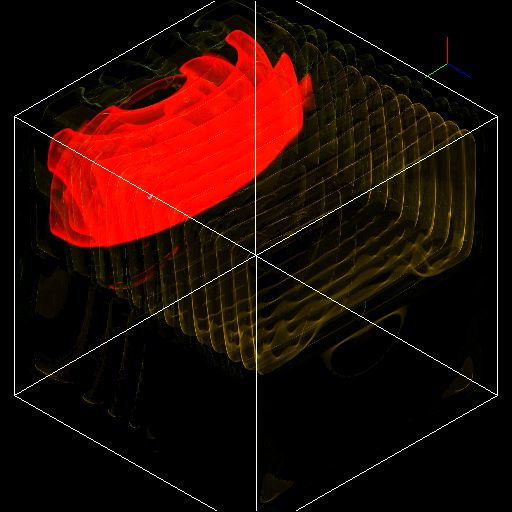

In [33]:
sc = yt.create_scene(YTDataObj, 'Sz')

#scTF = TransferFunctionHelper(YTDataObj)
#scTF.set_field('Sz')
#scTF.set_bounds((abs(Fields['Sz'][0].mean()-Fields['Sz'][0].std()), Fields['Sz'][0].mean()+Fields['Sz'][0].std()))
#scTF.set_log(True)
#sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


#scTF.plot(profile_field='Sz')

# Ex 2
this is the L waveguide example from the same tutorial found above modified to be three dimensional 

## setup and simultion

In [34]:
cell = mp.Vector3(16, 16, 16)
geometry = [mp.Block(mp.Vector3(12, 1, 1),
                     center=mp.Vector3(-2.5, -3.5, -2),
                     material=mp.Medium(epsilon=12)),
            mp.Block(mp.Vector3(1, 12, 1),
                     center=mp.Vector3(3.5, 2, 2),
                     material=mp.Medium(epsilon=12))]
pml_layers = [mp.PML(1.0)]
resolution = 10

In [35]:
sources = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                     component=mp.Ez,
                     center=mp.Vector3(-7,-3.5),
                     size=mp.Vector3(0,1))]

In [36]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


In [37]:
sim.run(until=100)

-----------
Initializing structure...
Meep progress: 0.05/100.0 = 0.1% done in 34.5s, 68935.6s to go
Meep progress: 0.65/100.0 = 0.7% done in 38.8s, 5932.9s to go
Meep progress: 1.25/100.0 = 1.2% done in 43.1s, 3407.2s to go
Meep progress: 1.85/100.0 = 1.9% done in 47.5s, 2518.7s to go
Meep progress: 2.45/100.0 = 2.5% done in 51.8s, 2061.8s to go
Meep progress: 3.0500000000000003/100.0 = 3.1% done in 56.1s, 1782.5s to go
Meep progress: 3.6500000000000004/100.0 = 3.7% done in 60.4s, 1593.7s to go
Meep progress: 4.25/100.0 = 4.2% done in 64.7s, 1457.0s to go
Meep progress: 4.8500000000000005/100.0 = 4.9% done in 69.0s, 1353.0s to go
Meep progress: 5.45/100.0 = 5.5% done in 73.3s, 1271.0s to go
Meep progress: 6.050000000000001/100.0 = 6.1% done in 77.6s, 1204.5s to go
Meep progress: 6.65/100.0 = 6.7% done in 81.9s, 1149.2s to go
Meep progress: 7.25/100.0 = 7.2% done in 86.2s, 1102.3s to go
Meep progress: 7.8500000000000005/100.0 = 7.9% done in 90.5s, 1062.3s to go
Meep progress: 8.4500000

Meep progress: 72.5/100.0 = 72.5% done in 554.3s, 210.2s to go
Meep progress: 73.10000000000001/100.0 = 73.1% done in 558.6s, 205.5s to go
Meep progress: 73.7/100.0 = 73.7% done in 562.9s, 200.9s to go
Meep progress: 74.3/100.0 = 74.3% done in 567.2s, 196.2s to go
Meep progress: 74.9/100.0 = 74.9% done in 571.4s, 191.5s to go
Meep progress: 75.5/100.0 = 75.5% done in 575.7s, 186.8s to go
Meep progress: 76.10000000000001/100.0 = 76.1% done in 580.0s, 182.2s to go
Meep progress: 76.7/100.0 = 76.7% done in 584.3s, 177.5s to go
Meep progress: 77.30000000000001/100.0 = 77.3% done in 588.6s, 172.9s to go
Meep progress: 77.9/100.0 = 77.9% done in 593.0s, 168.2s to go
Meep progress: 78.5/100.0 = 78.5% done in 597.3s, 163.6s to go
Meep progress: 79.10000000000001/100.0 = 79.1% done in 601.6s, 158.9s to go
Meep progress: 79.7/100.0 = 79.7% done in 605.9s, 154.3s to go
Meep progress: 80.30000000000001/100.0 = 80.3% done in 610.2s, 149.7s to go
Meep progress: 80.9/100.0 = 80.9% done in 614.5s, 145

limit_output extension: Maximum message size of 10000 exceeded with 10058 characters

## Capture the sim data

In [38]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric).T
eps_data.shape

In [39]:
ExData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ex).T
EyData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ey).T
EzData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez).T

EMagData=np.sqrt(ExData**2+ EyData**2+EzData**2)

EFields={'Ex':(ExData, 'g/m**3'), 'Ey':(EyData, 'g/m**3'), 'Ez':(EzData,'g/m**3'),
        'EMag':(EMagData,'g/m**3')}

In [40]:
BxData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Bx).T
ByData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.By).T
BzData = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Bz).T

BMagData=np.sqrt(BxData**2+ ByData**2+BzData**2)



BFields={'Bx':(BxData, 'g/m**3'), 'By':(ByData, 'g/m**3'), 'Bz':(BzData,'g/m**3'),
        'BMag':(BMagData,'g/m**3')}

In [41]:
SxData=PythongTMXEqN(EyData, EzData, ByData, BzData)
SyData=PythongTMYEqN(ExData, EzData, BxData, BzData)
SzData=PythongTMZEqN(ExData, EyData, ByData, BxData)

SMagData=np.sqrt(SxData**2+ SyData**2+SzData**2)

SFields={'Sx':(SxData, 'g/m**3'), 'Sy':(SyData, 'g/m**3'), 'Sz':(SzData,'g/m**3'),
        'SMag':(SMagData,'g/m**3')}


In [42]:
Fields={**EFields, **BFields, **SFields}; 

## yt vis

In [43]:
bbox = np.array([[-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5]])
YTDataObj = yt.load_uniform_grid(Fields, eps_data.shape, length_unit="m", bbox=bbox, nprocs=64)

yt : [INFO     ] 2018-05-21 11:54:24,951 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-21 11:54:24,951 Parameters: domain_dimensions         = [160 160 160]
yt : [INFO     ] 2018-05-21 11:54:24,952 Parameters: domain_left_edge          = [-1.5 -1.5 -1.5]
yt : [INFO     ] 2018-05-21 11:54:24,952 Parameters: domain_right_edge         = [1.5 1.5 1.5]
yt : [INFO     ] 2018-05-21 11:54:24,953 Parameters: cosmological_simulation   = 0.0


In [44]:
YTDataObj.field_list

[('stream', 'BMag'),
 ('stream', 'Bx'),
 ('stream', 'By'),
 ('stream', 'Bz'),
 ('stream', 'EMag'),
 ('stream', 'Ex'),
 ('stream', 'Ey'),
 ('stream', 'Ez'),
 ('stream', 'SMag'),
 ('stream', 'Sx'),
 ('stream', 'Sy'),
 ('stream', 'Sz')]

### E Fields

yt : [INFO     ] 2018-05-21 11:54:25,300 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:25,308 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:54:25,654 Creating transfer function
yt : [INFO     ] 2018-05-21 11:54:25,655 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


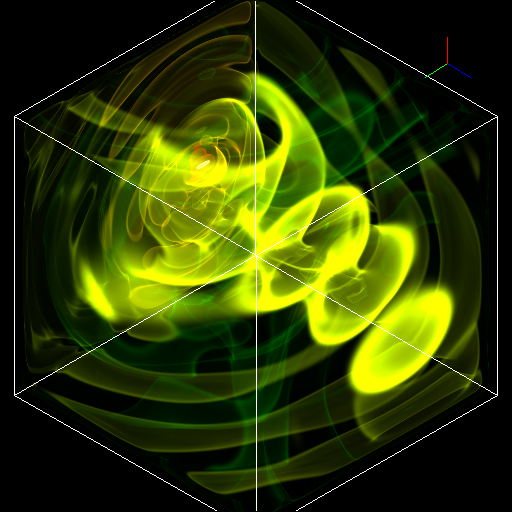

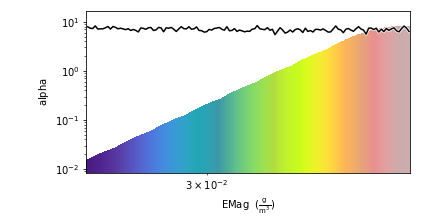

In [45]:
sc = yt.create_scene(YTDataObj, 'EMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('EMag')
scTF.set_bounds((abs(Fields['EMag'][0].mean()-Fields['EMag'][0].std()), Fields['EMag'][0].mean()+Fields['EMag'][0].std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='EMag')

yt : [INFO     ] 2018-05-21 11:54:33,111 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:33,118 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:54:33,592 Creating transfer function
yt : [INFO     ] 2018-05-21 11:54:33,593 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


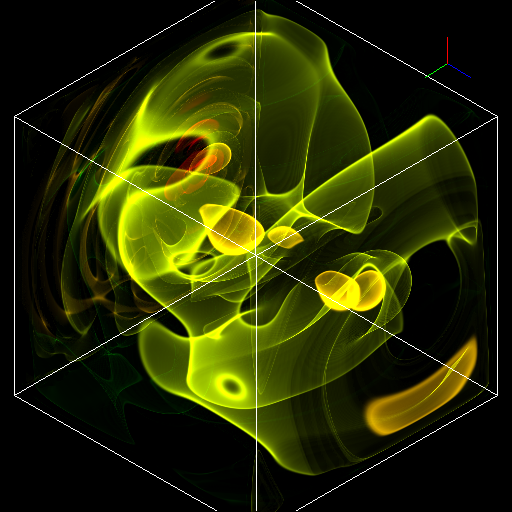

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


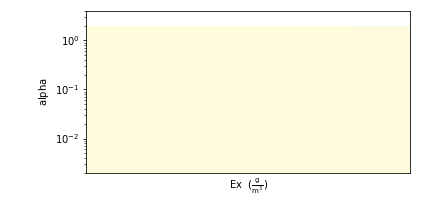

In [46]:
sc = yt.create_scene(YTDataObj, 'Ex')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ex')
scTF.set_bounds((abs(Fields['Ex'][0].mean()-Fields['Ex'][0].std()), Fields['Ex'][0].mean()+Fields['Ex'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ex')

yt : [INFO     ] 2018-05-21 11:54:39,944 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:39,950 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:54:40,412 Creating transfer function
yt : [INFO     ] 2018-05-21 11:54:40,413 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


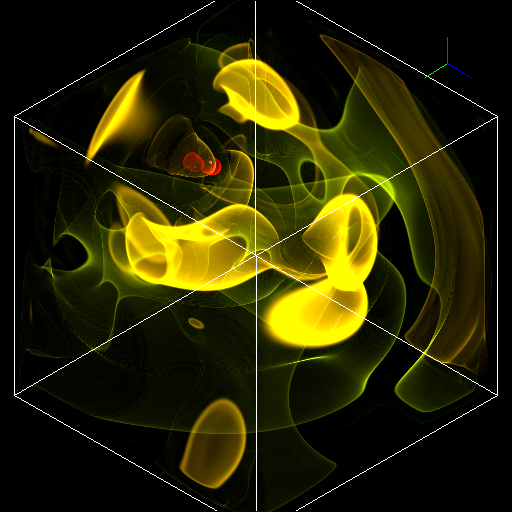

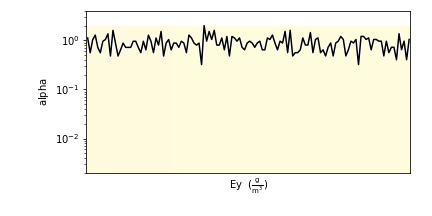

In [47]:
sc = yt.create_scene(YTDataObj, 'Ey')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ey')
scTF.set_bounds((abs(Fields['Ey'][0].mean()-Fields['Ey'][0].std()), Fields['Ey'][0].mean()+Fields['Ey'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ey')

yt : [INFO     ] 2018-05-21 11:54:46,277 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:46,283 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:54:46,754 Creating transfer function
yt : [INFO     ] 2018-05-21 11:54:46,755 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


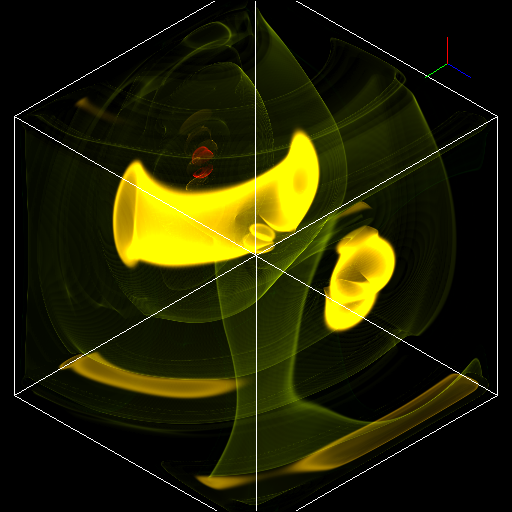

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


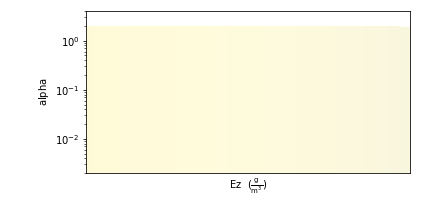

In [48]:
sc = yt.create_scene(YTDataObj, 'Ez')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Ez')
scTF.set_bounds((abs(Fields['Ez'][0].mean()-Fields['Ez'][0].std()), Fields['Ez'][0].mean()+Fields['Ez'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Ez')

### B Fields

yt : [INFO     ] 2018-05-21 11:54:52,784 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:52,790 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:54:53,050 Creating transfer function
yt : [INFO     ] 2018-05-21 11:54:53,051 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


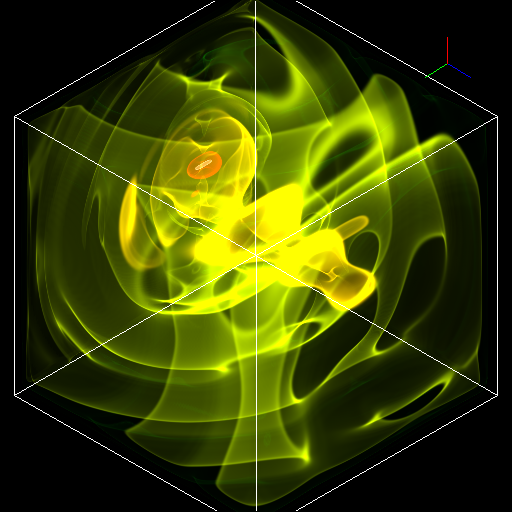

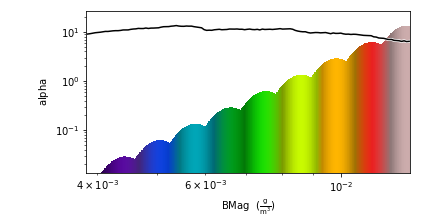

In [49]:
sc = yt.create_scene(YTDataObj, 'BMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('BMag')
scTF.set_bounds((abs(Fields['BMag'][0].mean()-Fields['BMag'][0].std()), Fields['BMag'][0].mean()+Fields['BMag'][0].std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='BMag')

yt : [INFO     ] 2018-05-21 11:54:59,852 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:54:59,859 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:00,361 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:00,361 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


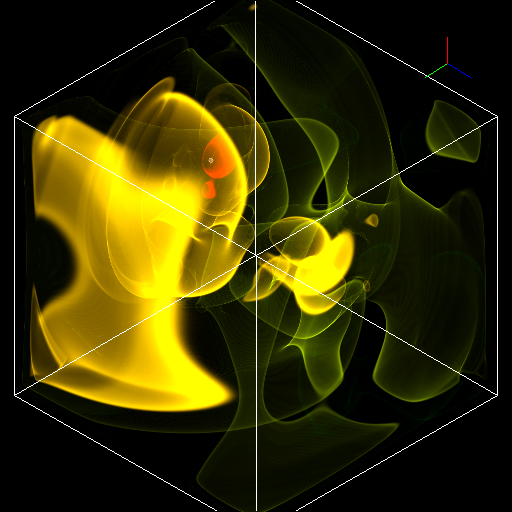

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


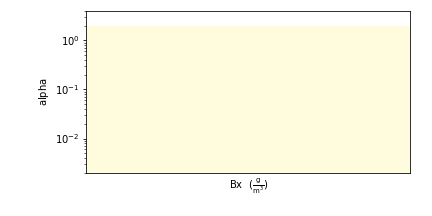

In [50]:
sc = yt.create_scene(YTDataObj, 'Bx')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Bx')
scTF.set_bounds((abs(Fields['Bx'][0].mean()-Fields['Bx'][0].std()), Fields['Bx'][0].mean()+Fields['Bx'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Bx')

yt : [INFO     ] 2018-05-21 11:55:06,419 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:06,426 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:06,870 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:06,871 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


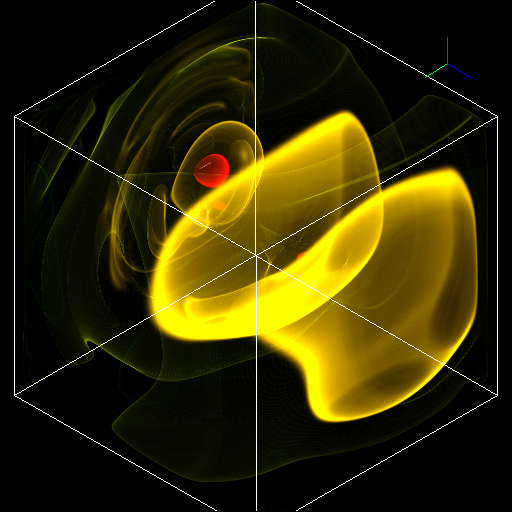

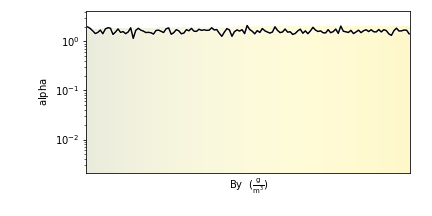

In [51]:
sc = yt.create_scene(YTDataObj, 'By')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('By')
scTF.set_bounds((abs(Fields['By'][0].mean()-Fields['By'][0].std()), Fields['By'][0].mean()+Fields['By'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='By')

yt : [INFO     ] 2018-05-21 11:55:13,200 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:13,207 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:13,653 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:13,654 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


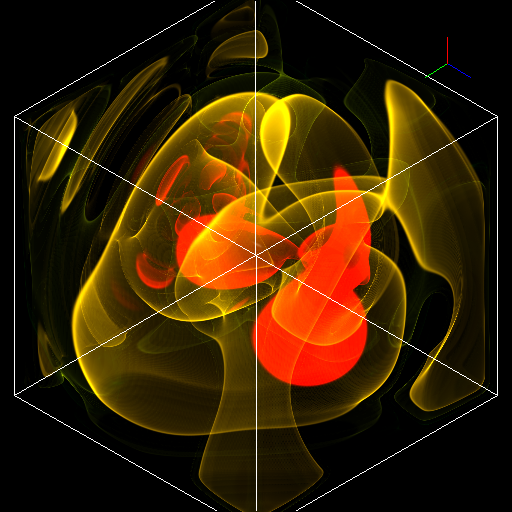

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


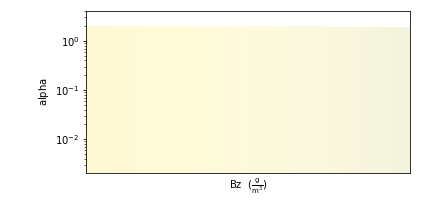

In [52]:
sc = yt.create_scene(YTDataObj, 'Bz')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Bz')
scTF.set_bounds((abs(Fields['Bz'][0].mean()-Fields['Bz'][0].std()), Fields['Bz'][0].mean()+Fields['Bz'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Bz')

### Power Fields

yt : [INFO     ] 2018-05-21 11:55:20,151 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:20,158 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:20,429 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:20,430 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


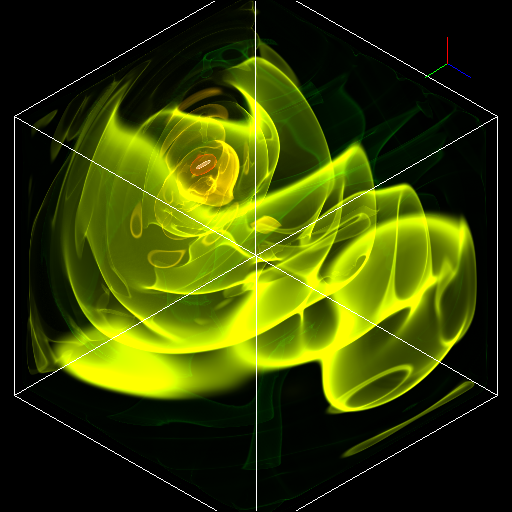

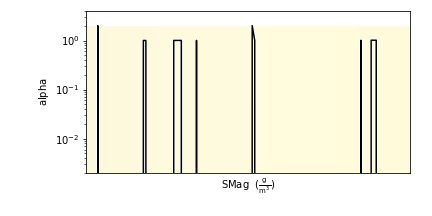

In [53]:
sc = yt.create_scene(YTDataObj, 'SMag')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('SMag')
scTF.set_bounds((abs(Fields['SMag'][0].mean()-Fields['SMag'][0].std()), Fields['SMag'][0].mean()+Fields['SMag'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='SMag')

yt : [INFO     ] 2018-05-21 11:55:28,179 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:28,187 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:28,544 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:28,545 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


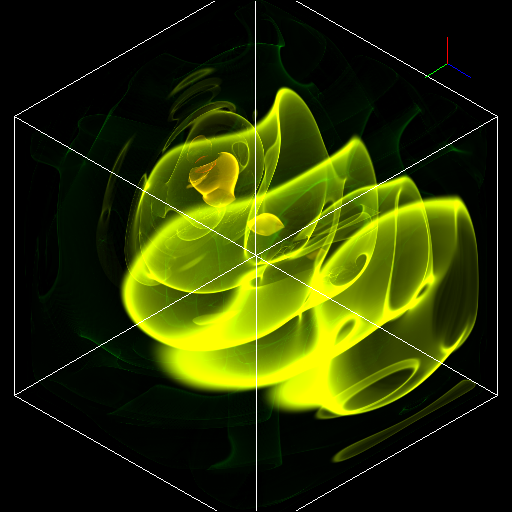

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


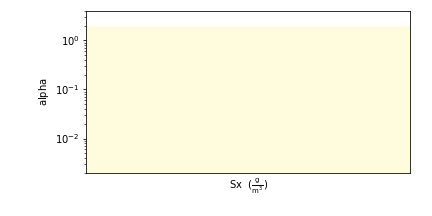

In [54]:
sc = yt.create_scene(YTDataObj, 'Sx')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Sx')
scTF.set_bounds((abs(Fields['Sx'][0].mean()-Fields['Sx'][0].std()), Fields['Sx'][0].mean()+Fields['Sx'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Sx')

yt : [INFO     ] 2018-05-21 11:55:36,557 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:36,563 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:36,950 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:36,951 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


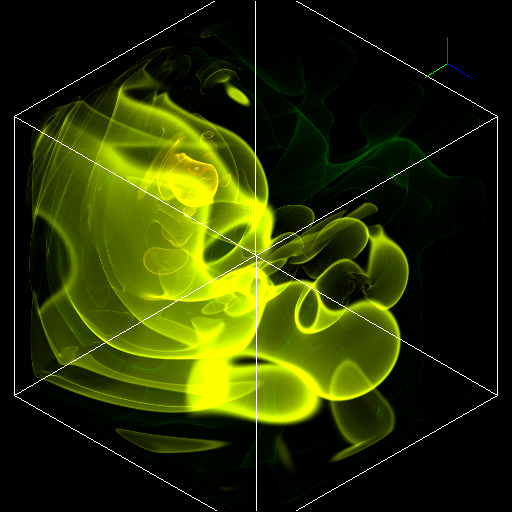

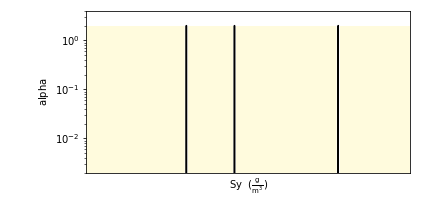

In [55]:
sc = yt.create_scene(YTDataObj, 'Sy')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Sy')
scTF.set_bounds((abs(Fields['Sy'][0].mean()-Fields['Sy'][0].std()), Fields['Sy'][0].mean()+Fields['Sy'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Sy')

yt : [INFO     ] 2018-05-21 11:55:44,176 Rendering scene (Can take a while).
yt : [INFO     ] 2018-05-21 11:55:44,182 Creating volume
/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1293: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)
yt : [INFO     ] 2018-05-21 11:55:44,665 Creating transfer function
yt : [INFO     ] 2018-05-21 11:55:44,666 Calculating data bounds. This may take a while.  Set the TransferFunctionHelper.bounds to avoid this.


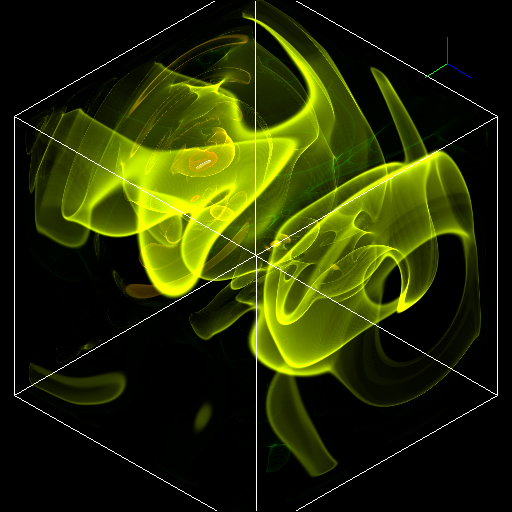

/home/iridium/anaconda3/envs/mp/lib/python3.6/site-packages/yt/units/yt_array.py:1314: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)


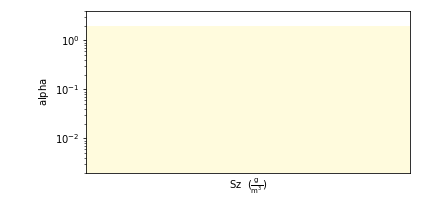

In [56]:
sc = yt.create_scene(YTDataObj, 'Sz')

scTF = TransferFunctionHelper(YTDataObj)
scTF.set_field('Sz')
scTF.set_bounds((abs(Fields['Sz'][0].mean()-Fields['Sz'][0].std()), Fields['Sz'][0].mean()+Fields['Sz'][0].std()))
#scTF.set_log(True)
sc.transfer_function=scTF.tf


sc.annotate_axes()
sc.annotate_domain(YTDataObj)


sc.show(sigma_clip=2)


scTF.plot(profile_field='Sz')

# Conclusion
While the process of collecting the data and visualizing needs more work it is clear that with improvements to yt that it is more than capable of providing an in-process visualization pipeline for fields returned by meep. And if I knew how to utilize meep better that would substantially help but this is a step for myself and other learning it since we can now visualize the outputs directly in the jupyter notebook without having to resort to external file management and visualization